In [ ]:
############################################
# Team : RAGrats      
# Team Members : Ali Asgar Padaria, Param Patel, Meet Zalavadiya
#                    
# Code Description : This file contains the code for the Improvement 2 Model - Specifically the retriever part
#                    It builds up on baseline 2 in a way that here we try to improve the retriever by training 
#                    the SentenceTransformer with our context list so that it might provide better relevant embeddings. 
#                    After training the SentenceTransformer, we extract the relevant contexts for questions in validation 
#                    set to be used in the second part, the generation
#                    
# NLP Concepts Usage: Tokenization, Embeddings
#                       
# System : GCP Server L4 GPU
#############################################

In [ ]:
# Import necessary libraries

from datasets import load_dataset, load_from_disk
from collections import defaultdict
from sentence_transformers import SentenceTransformer, InputExample, losses, models
from torch.utils.data import DataLoader
import random
import torch
import faiss
import numpy as np
from datasets import concatenate_datasets
from tqdm import tqdm
import json
from torch.cuda.amp import autocast
from torch.amp import GradScaler
import matplotlib.pyplot as plt
import os

In [2]:
train_dataset = load_from_disk("../files/train_dataset")
val_dataset = load_from_disk("../files/val_dataset")

In [4]:
# Get Passages from Train and Val Datasets
train_contexts = list({context for item in train_dataset for context in item["context"]["contexts"]})
val_contexts = list({context for item in val_dataset for context in item["context"]["contexts"]})

# merge train and val contexts
all_contexts = list(set(train_contexts) | set(val_contexts))

train_samples = []
for item in train_dataset:
    question = item["question"]
    positives = item["context"]["contexts"]
    if not positives:
        continue
    for pos in positives:
        train_samples.append(InputExample(texts=[question, pos], label=1.0))
        # Sample a negative
        while True:
            neg = random.choice(train_contexts)
            if neg not in positives:
                break
        train_samples.append(InputExample(texts=[question, neg], label=0.0))

In [ ]:
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2") # NLP Concept : Tokenization, Embeddings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/var/tmp/ipykernel_207533/2784799820.py:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/2:   0%|          | 0/14318 [00:00<?, ?it/s]/var/tmp/ipykernel_207533/2784799820.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Loss curve saved to: /home/apadaria/NLP_Project/source/improvement_2/outputs/training_loss_curve_per_batch.png


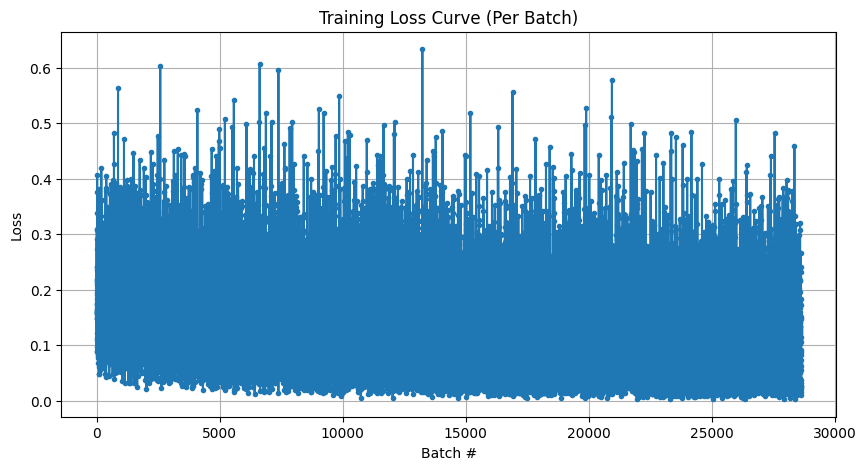

Model saved to: ./cosine-retriever-pubmedqa


In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import matplotlib.pyplot as plt
import os


train_dataloader = DataLoader(
    train_samples,
    batch_size=8,
    collate_fn=lambda x: x  
)

# Optimizer and scaler
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
scaler = GradScaler()

# Loss function
cosine_loss = torch.nn.CosineEmbeddingLoss()

# Training setup
epochs = 2
batch_losses = []

for epoch in range(epochs):
    model.train()
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

    for batch in progress_bar:
        sentences1 = [example.texts[0] for example in batch]
        sentences2 = [example.texts[1] for example in batch]
        labels = torch.tensor([example.label for example in batch], dtype=torch.float).to(device)

        optimizer.zero_grad()

        # Tokenize manually for forward()
        features1 = {k: v.to(device) for k, v in model.tokenize(sentences1).items()}
        features2 = {k: v.to(device) for k, v in model.tokenize(sentences2).items()}

        with autocast():
            embeddings1 = model.forward(features1)['sentence_embedding']
            embeddings2 = model.forward(features2)['sentence_embedding']
            label_adjusted = torch.where(labels > 0.5, 1.0, -1.0).to(device)
            loss = cosine_loss(embeddings1, embeddings2, label_adjusted)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        batch_losses.append(loss.item())
        progress_bar.set_postfix({"Batch Loss": loss.item()})

# Save and plot batch loss curve
output_dir = "/home/apadaria/NLP_Project/source/improvement_2/outputs"
os.makedirs(output_dir, exist_ok=True)

plt.figure(figsize=(10, 5))
plt.plot(batch_losses, marker='.')
plt.xlabel("Batch #")
plt.ylabel("Loss")
plt.title("Training Loss Curve (Per Batch)")
plt.grid(True)

plot_path = os.path.join(output_dir, "training_loss_curve_per_batch.png")
plt.savefig(plot_path)
print(f"Loss curve saved to: {plot_path}")
plt.show()

# Save model
output_path = "./cosine-retriever-pubmedqa"
model.save(output_path)
print(f"Model saved to: {output_path}")

In [ ]:
# Save and plot batch loss curve
output_dir = "/home/apadaria/NLP_Project/source/improvement_2/outputs"
os.makedirs(output_dir, exist_ok=True)
smoothed_losses = np.convolve(batch_losses, np.ones(200)/200, mode='valid')
plt.figure(figsize=(10, 5))
plt.plot(batch_losses, marker='.')
plt.xlabel("Batch #")
plt.ylabel("Loss")
plt.title("Training Loss Curve (Per Batch)")
plt.grid(True)

plot_path = os.path.join(output_dir, "training_loss_curve_per_batch.png")
plt.savefig(plot_path)
print(f"Loss curve saved to: {plot_path}")
plt.show()

# Save model
output_path = "./cosine-retriever-pubmedqa"
model.save(output_path)
print(f"Model saved to: {output_path}")

In [36]:
model = SentenceTransformer("./cosine-retriever-pubmedqa")
model = model.to(device)

Evaluate Retriever

In [ ]:
with open("../files/contexts.json", "r") as f:
    all_contexts = json.load(f)

In [37]:
context_embeddings = model.encode(val_contexts, batch_size=16, convert_to_numpy=True, show_progress_bar=True)
index = faiss.IndexFlatL2(context_embeddings.shape[1])
index.add(context_embeddings)
faiss.write_index(index, "../files/improvement2_retriever_faiss.index")

Batches:   0%|          | 0/398 [00:00<?, ?it/s]

In [29]:
full_dataset = concatenate_datasets([train_dataset, val_dataset])

In [38]:
def retrieval_evaluation(dataset, index, contexts):
    total_matched = 0
    total_expected = 0

    for item in tqdm(dataset):
        question = item["question"]
        gold_contexts = set(item["context"]["contexts"])
        if not gold_contexts:
            continue

        # Encode the query
        query_embedding = model.encode([question])[0]

        # Retrieve top-N results where N = number of gold contexts
        _, I = index.search(query_embedding.reshape(1, -1), len(gold_contexts))

        retrieved_contexts = {contexts[i] for i in I[0]}
        matched = len(gold_contexts & retrieved_contexts)

        total_matched += matched
        total_expected += len(gold_contexts)

    return total_matched / total_expected if total_expected else 0.0

In [39]:
index = faiss.read_index("../files/improvement2_retriever_faiss.index")
retrieval_accuracy = retrieval_evaluation(val_dataset, index, val_contexts)
print(f"Retrieval Accuracy: {retrieval_accuracy:.4f}")

100%|██████████| 2000/2000 [00:22<00:00, 88.69it/s]

Retrieval Accuracy: 0.5262


Store Retrieved Context Pairs for Validation Set

In [69]:
val_dataset

Dataset({
    features: ['pubid', 'question', 'context', 'long_answer', 'final_decision'],
    num_rows: 2000
})

In [70]:
def retrieve_for_validation_set(dataset, index, contexts, k=5):
    retreived_pairas = []
    for item in tqdm(dataset):
        query = item["question"]
        query_embedding = model.encode([query])[0]

        _, I = index.search(query_embedding.reshape(1, -1), 5)

        retrieved_contexts = [contexts[i] for i in I[0]]
        
        # store question and retireved contexts in a dict object
        retreived_pairas.append({
            "question": query,
            "retrieved_contexts": retrieved_contexts
        })
    return retreived_pairas


In [71]:
retreived_pairs = retrieve_for_validation_set(val_dataset, index, val_contexts)

100%|██████████| 2000/2000 [00:24<00:00, 81.28it/s]


In [73]:
# save this file
with open("../files/val_retrieved_pairs_improv_2.json", "w") as f:
    json.dump(retreived_pairs, f)


In [75]:
retreived_pairs

[{'question': 'Does functional status predict complicated clinical course in older adults in the emergency department with infection?',
  'retrieved_contexts': ['To identify the relationship between functional status and complicated clinical course in older adults in the emergency department (ED) with suspected infection and to identify other independent predictors of complicated clinical course.',
   'One hundred five participants were enrolled, 34 with the primary outcome. OARS was not predictive of complicated clinical course in univariate (P\xa0=\xa0.13) or multivariable (P\xa0=\xa0.90) models. An OARS score of 25 or less was also not significant (P\xa0=\xa0.22). Independent predictors were immunosuppression (odds ratio (OR)\xa0=\xa03.45, 95% confidence interval (CI)\xa0=\xa01.06-11.20), systolic blood pressure (OR\xa0=\xa00.98, 95% CI\xa0=\xa00.96-1.00), pulse (OR\xa0= 1.03, 95% CI\xa0=\xa01.00-1.06), metabolic acidosis (OR\xa0=\xa03.46, 95% CI\xa0=\xa01.08-11.09), severe sepsis o